In [3]:
 ! pip install -q kaggle

In [4]:
from google.colab import files

In [5]:
kaggle=files.upload()

Saving kaggle.json to kaggle.json


In [6]:
! mkdir ~/.kaggle

In [7]:
! cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
 ! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-12-12 11:59:54          18415  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01          11088  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           5661  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-10-22 10:48:21           3922  
nickuzmenkov/nih-chest-xrays-tfrecords                      NIH Chest X-rays

In [10]:
! kaggle competitions download -c 'challenges-in-representation-learning-facial-expression-recognition-challenge'

  0% 0.00/7.01k [00:00<?, ?B/s]
100% 7.01k/7.01k [00:00<00:00, 2.82MB/s]
 80% 74.0M/92.0M [00:00<00:00, 74.1MB/s]
100% 92.0M/92.0M [00:01<00:00, 94.8MB/s]
 87% 67.0M/77.3M [00:00<00:00, 126MB/s]
100% 77.3M/77.3M [00:00<00:00, 131MB/s]
 88% 85.0M/96.6M [00:00<00:00, 162MB/s]
100% 96.6M/96.6M [00:00<00:00, 153MB/s]
 41% 8.00M/19.3M [00:00<00:00, 82.7MB/s]
100% 19.3M/19.3M [00:00<00:00, 94.0MB/s]


In [11]:
!kaggle datasets download -d deadskull7/fer2013

 95% 92.0M/96.6M [00:01<00:00, 82.1MB/s]
100% 96.6M/96.6M [00:01<00:00, 71.2MB/s]


In [12]:
!unzip \*.zip && rm *.zip

Archive:  test.csv.zip
  inflating: test.csv                

Archive:  fer2013.zip
  inflating: fer2013.csv             

Archive:  icml_face_data.csv.zip
  inflating: icml_face_data.csv      

Archive:  train.csv.zip
  inflating: train.csv               

4 archives were successfully processed.


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


np.random.seed(2)
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
import keras.optimizers as opt
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers.core import Dropout, Flatten, Dense
from keras.layers import Input

In [14]:
data = pd.read_csv("fer2013.csv")


In [15]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [16]:
data.shape

(35887, 3)

In [17]:
data["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [18]:
groups = [g for _, g in data.groupby('Usage')]
train = groups[2]
val = groups[1]
test = groups[0]

In [19]:
train = train.drop(labels=['Usage'], axis=1)
val = val.drop(labels=['Usage'], axis=1)
test = test.drop(labels=['Usage'], axis=1)

Y_train = train["emotion"]
Y_val = val["emotion"]
Y_test = test["emotion"]
#'Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'#

X_train = train["pixels"]
X_val = val["pixels"]
X_test = test["pixels"]

In [20]:
def preprocess(X):
    X = np.array([np.fromstring(image, np.uint8, sep=' ') for image in X])
    X = X/255.0
    X = X.reshape(-1, 48, 48, 1)
    return X

In [21]:
X_train = preprocess(X_train)
X_val = preprocess(X_val)
X_test = preprocess(X_test)

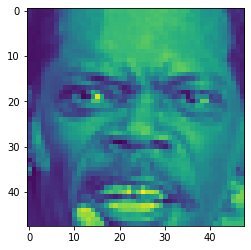

In [22]:
plt.imshow(X_train[10][:,:,0])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Counts per emotion in testing set')

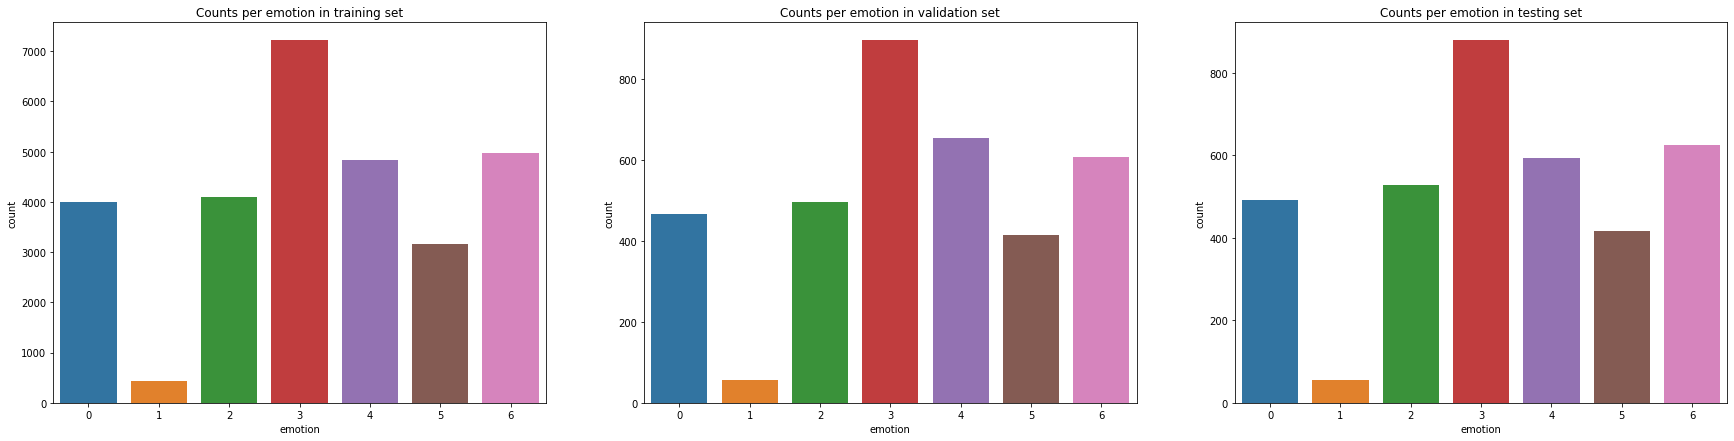

In [23]:
plt.figure(figsize=(30, 7))

plt.subplot(1,3,1)
ax = sns.countplot(Y_train)
ax.set(ylabel="count", xlabel="emotion")
plt.title("Counts per emotion in training set")

plt.subplot(1,3,2)
ax = sns.countplot(Y_val)
ax.set(ylabel="count", xlabel="emotion")
plt.title("Counts per emotion in validation set")

plt.subplot(1,3,3)
ax = sns.countplot(Y_test)
ax.set(ylabel="count", xlabel="emotion")
plt.title("Counts per emotion in testing set")

In [24]:
print("Is any label null in training set:", Y_train.isnull().any())
print("Is any label null in validation set:", Y_val.isnull().any())
print("Is any label null in testing set:", Y_test.isnull().any())


Y_train = to_categorical(Y_train, num_classes=7)
Y_val = to_categorical(Y_val, num_classes=7)
Y_test = to_categorical(Y_test, num_classes=7)

Is any label null in training set: False
Is any label null in validation set: False
Is any label null in testing set: False


In [25]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding="Same", activation='relu', input_shape=(48,48,1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(32, (5,5), padding="Same", activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(64, (3,3), padding="Same", activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(64, (5,5), padding="Same", activation='relu'))
model.add(MaxPooling2D((2,2))) 
model.add(Dropout(0.5))
model.add(Conv2D(128, (3,3), padding="Same", activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(128, (5,5), padding="Same", activation='relu'))
model.add(MaxPooling2D((2,2))) 
model.add(Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [26]:
optimizer = tf.keras.optimizers.Adam(lr = 0.001)
lr_anneal = ReduceLROnPlateau(monitor = 'val_accuracy', patience=3, factor=0.2, min_lr=1e-6)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [27]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        1

In [29]:
lr_anneal = ReduceLROnPlateau(monitor = 'val_accuracy', patience=2, factor=0.2, min_lr=1e-6,restore_best_weights=True)

In [30]:
history = model.fit(X_train, Y_train, validation_data=[X_val, Y_val], epochs=50, batch_size = 100, callbacks = [lr_anneal])

Epoch 1/50
288/288 [==============================] - 32s 66ms/step - loss: 1.7467 - accuracy: 0.3161 - val_loss: 1.9968 - val_accuracy: 0.1767 - lr: 0.0010
Epoch 2/50
288/288 [==============================] - 19s 65ms/step - loss: 1.4850 - accuracy: 0.4213 - val_loss: 1.6630 - val_accuracy: 0.3477 - lr: 0.0010
Epoch 3/50
288/288 [==============================] - 21s 73ms/step - loss: 1.3522 - accuracy: 0.4769 - val_loss: 1.3435 - val_accuracy: 0.4820 - lr: 0.0010
Epoch 4/50
288/288 [==============================] - 19s 65ms/step - loss: 1.2710 - accuracy: 0.5141 - val_loss: 1.2249 - val_accuracy: 0.5252 - lr: 0.0010
Epoch 5/50
288/288 [==============================] - 19s 65ms/step - loss: 1.2082 - accuracy: 0.5359 - val_loss: 1.3142 - val_accuracy: 0.5188 - lr: 0.0010
Epoch 6/50
288/288 [==============================] - 18s 64ms/step - loss: 1.1631 - accuracy: 0.5567 - val_loss: 1.2247 - val_accuracy: 0.5366 - lr: 0.0010
Epoch 7/50
288/288 [==============================] - 18s 

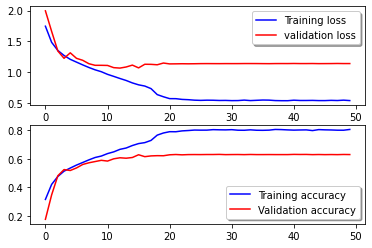

In [31]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)
ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


In [32]:
score, acc = model.evaluate(X_test, Y_test, batch_size=100)
print('Test score:', score)
print("Test accuracy:", acc)

36/36 [==============================] - 1s 23ms/step - loss: 1.1011 - accuracy: 0.6464
Test score: 1.101090908050537
Test accuracy: 0.6464196443557739


In [33]:
model.save('deep_learnin_project.h5')

In [34]:
model.save_weights('deep_learnin_project.ckpt')